# Описание проекта

Поступила задача: приоритезировать гипотезы(которые совместно с отделом маркетинга были подготовлены для увеличения выручки), запустить A/B-тест и проанализировать результаты. 

# Часть 1: Описание данных

Файл /datasets/hypothesis.csv.
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале; 
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале.
- Чем больше значение Efforts, тем дороже проверка гипотезы.

# Задача

- Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import math as mth
import datetime as dt
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
data = pd.read_csv('/datasets/hypothesis.csv')
data

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Видно, что данные в порядке. Можно начинать анализ

In [3]:
# Посчитайем ICE для гипотез.
data['ICE'] = data['Impact'] * data['Confidence'] / data['Efforts']
print(data[["Hypothesis", "ICE"]].sort_values(by='ICE', ascending=False))

                                          Hypothesis        ICE
8  Запустить акцию, дающую скидку на товар в день...  16.200000
0  Добавить два новых канала привлечения трафика,...  13.333333
7  Добавить форму подписки на все основные страни...  11.200000
6  Показать на главной странице баннеры с актуаль...   8.000000
2  Добавить блоки рекомендаций товаров на сайт ин...   7.000000
1  Запустить собственную службу доставки, что сок...   2.000000
5  Добавить страницу отзывов клиентов о магазине,...   1.333333
3  Изменить структура категорий, что увеличит кон...   1.125000
4  Изменить цвет фона главной страницы, чтобы уве...   1.000000


Наиболее перспективные гипотезы по ICE: 8, 0 и 7

In [4]:
data['RICE'] = data['Reach'] * data['Impact'] * data['Confidence'] / data['Efforts']
print(data[["Hypothesis", "RICE"]].sort_values(by='RICE', ascending=False))
pd.options.display.max_colwidth = 50

                                          Hypothesis   RICE
7  Добавить форму подписки на все основные страни...  112.0
2  Добавить блоки рекомендаций товаров на сайт ин...   56.0
0  Добавить два новых канала привлечения трафика,...   40.0
6  Показать на главной странице баннеры с актуаль...   40.0
8  Запустить акцию, дающую скидку на товар в день...   16.2
3  Изменить структура категорий, что увеличит кон...    9.0
1  Запустить собственную службу доставки, что сок...    4.0
5  Добавить страницу отзывов клиентов о магазине,...    4.0
4  Изменить цвет фона главной страницы, чтобы уве...    3.0


Наиболее перспективные гипотезы по КICE: 7, 2 и 0

Разница в приотритетах гипотез состоит в том, что RICE учитывает не только "силу гипотез", но и то как много пользователей она затронет. Поэтому гипотеза 7 выбилась вперед, т.к. ее Reach максимальный = 10. 

# Часть 2: Описание данных

Файл /datasets/orders.csv
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.


Файл /datasets/visitors.csv
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста


# Задача

Проанализируйте A/B-тест  :)

In [5]:
orders = pd.read_csv('/datasets/orders.csv')
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
print('\nНачальная дата {}, конечная дата {}\n'.format(orders['date'].min(), orders['date'].max()))
orders.info()


Начальная дата 2019-08-01 00:00:00, конечная дата 2019-08-31 00:00:00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [6]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Проверим нет ли пользователей, которые оказались в обеих группах одновременно

In [7]:
group_sizes = orders.groupby(['visitorId']).size().reset_index()
group_sizes.columns = ['visitorId', 'count']
group_sizes = group_sizes.query('count > 2').sort_values(by='visitorId')
group_sizes

,visitorId,count
44,199603092,5
55,237748145,5
59,249864742,3
97,393266494,3
114,457167155,4
148,611059232,3
299,1230306981,5
311,1294878855,3
340,1404934699,3
393,1614305549,4


In [8]:
ordersab = orders.drop_duplicates(subset=['visitorId','group'])
ordersab = ordersab.groupby('visitorId', as_index=False)['group'].count()
ordersab.columns = ['visitorId', 'groups']
ordersab[ordersab['groups']==2].count()

visitorId    58
groups       58
dtype: int64

In [9]:
ab_list = ordersab[ordersab['groups']==2]['visitorId'].tolist()
orders = orders.query('visitorId not in @ab_list')

In [10]:
ordersab = orders.drop_duplicates(subset=['visitorId','group'])
ordersab = ordersab.groupby('visitorId', as_index=False)['group'].count()
ordersab.columns = ['visitorId', 'groups']
ordersab[ordersab['groups']==2].count()

visitorId    0
groups       0
dtype: int64

# Проверим корректность распределения на группы A/B

Необходимо проверить размеры групп в выборке, есть ли разница между ними, а также проверить, корректно ли был рассчитан размер выборки для проведения теста

Кол-во посетителей в группе А: 18736
Кол-во посетителей в группе B: 18916
Кол-во покупок в группе A: 468
Кол-во покупок в группе B: 548


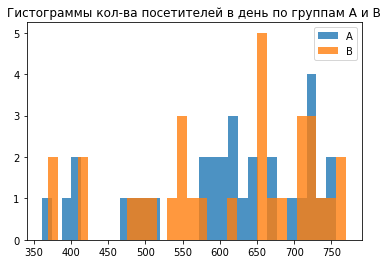

P-value:0.7301376549390499
Разница в количестве посетителей в группах A и B статистически НЕ значима



In [11]:
print('Кол-во посетителей в группе А: {}\n'
      'Кол-во посетителей в группе B: {}'.format(visitors[visitors['group']=='A']['visitors'].sum(), 
                                                 visitors[visitors['group']=='B']['visitors'].sum()))
purchasesA = len(orders[orders['group']=='A'])
purchasesB = len(orders[orders['group']=='B'])
print('Кол-во покупок в группе A: {}'.format(purchasesA))
print('Кол-во покупок в группе B: {}'.format(purchasesB))
plt.hist(visitors[visitors['group']=='A']['visitors'], alpha = 0.8, label='A', bins = 30)
plt.hist(visitors[visitors['group']=='B']['visitors'], alpha = 0.8, label='B', bins = 30)
plt.legend()
plt.title('Гистограммы кол-ва посетителей в день по группам A и B')
plt.show()
results = st.mannwhitneyu(visitors[visitors['group']=='A']['visitors'], visitors[visitors['group']=='B']['visitors'])
alpha = 0.05
print('P-value:{}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Разница в количестве посетителей в группах A и B статистически значима\n')
else:
    print('Разница в количестве посетителей в группах A и B статистически НЕ значима\n')

initial_conversion = len(orders[orders['group']=='A']) / visitors[visitors['group']=='A']['visitors'].sum() 
resulting_conversion = len(orders[orders['group']=='B']) / visitors[visitors['group']=='B']['visitors'].sum()

Вводим начальную конверсию и полученное относительное изменение конверсии в калькулятор.
Сайт калькулятора: https://www.evanmiller.org/ab-testing/sample-size.html
Получаем необходимое количество выборки 35855 для корректного проведения тестирования.
В нашем случае количество 37652 посещений.
Кол-во выборки для A/B тестирования корректно подобрано, статистически значимой разницы
в количестве посещений м/у группами не обнаружено.

Ок, идём дальше.

*** Начнем сбор кумулятивных данных ***

In [12]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head())

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


Построим график кумулятивной выручки по группам

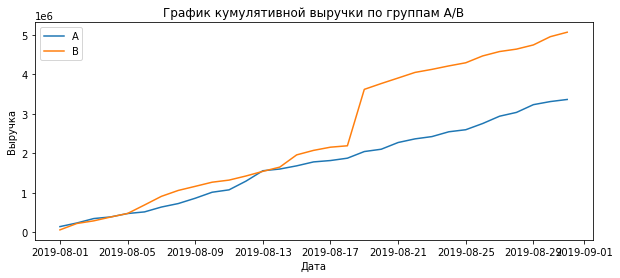

In [13]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.figure(figsize=(10,4))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.title('График кумулятивной выручки по группам A/B')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.show()

Почти в середине теста группа B вырвалась вперед и продолжала лидировать весь тест. Похоже что есть аномально большие заказы.

2) Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

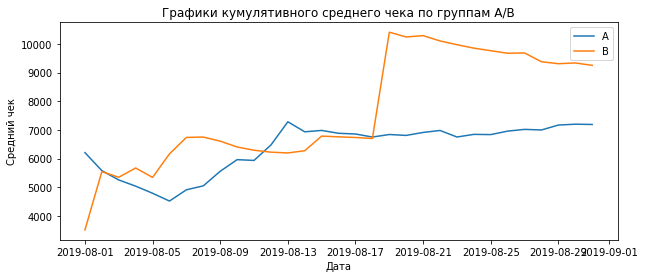

In [14]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']
]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']
]
plt.figure(figsize=(10,4))
plt.title('Графики кумулятивного среднего чека по группам A/B')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.show()

По графику видно, что в середине теста была произведена очень большая покупка и благодаря ей группа B вырвалась вперед.

3) Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

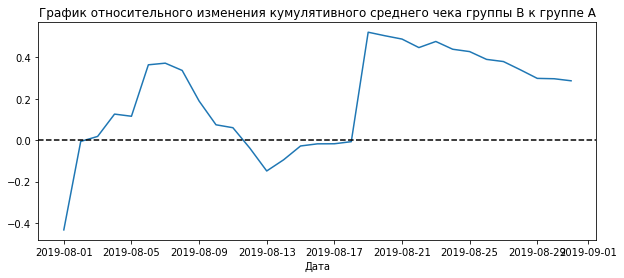

In [15]:

cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']
]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']
]

mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10,4))
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

В течении теста результаты резко менялись несколько раз. Именно тогда были произведены большие покупки

4) Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.

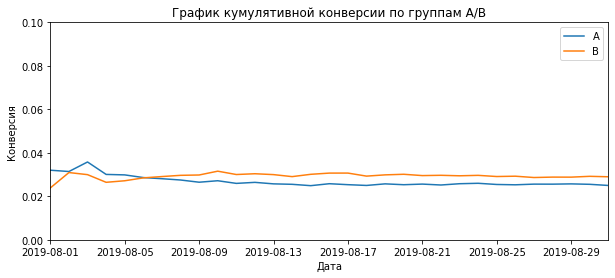

In [16]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
plt.figure(figsize=(10,4))
plt.title('График кумулятивной конверсии по группам A/B')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0, 0.10])
plt.show()

Группа B постепенно выровнялась и зафиксировалась на одном значении, большем чем у группы A

5) Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.

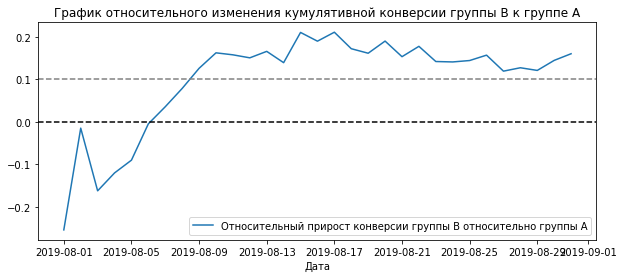

In [17]:
cumulativeData['conversion'] = (
    cumulativeData['orders'] / cumulativeData['visitors']
)

cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10,4))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')

plt.axhline(y=0.1, color='grey', linestyle='--')
plt.show()

Конверсия в группе B стабильно лучше конверсии в группе A на 10% по просшествии 1 недели после начала

# Анализ выбросов

6) Построим точечный график количества заказов по пользователям. 

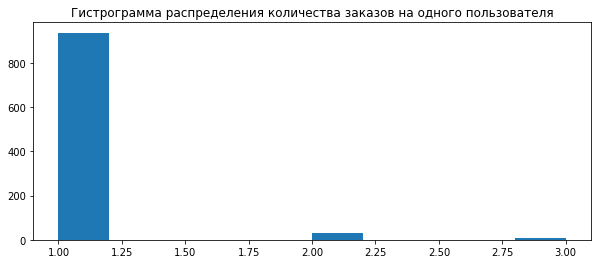

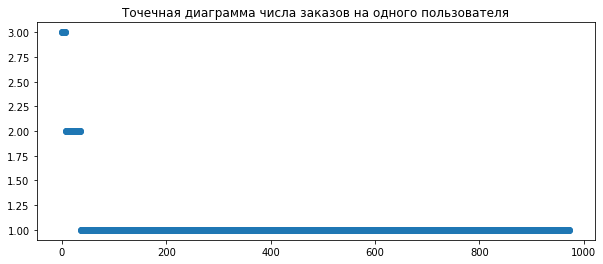

Выводы:
Судя по граифкам, подавляющее большинство пользователей не совершает более 2 заказов


In [18]:
orders.head(5)
ordersByUsers = orders.groupby('visitorId', as_index = False).agg({'transactionId':'nunique'}).sort_values(by='transactionId', ascending = False)
ordersByUsers.columns = ['visitorId', 'orders']
ordersByUsers.head(5)
plt.figure(figsize=(10,4))
plt.hist(ordersByUsers['orders'], bins = 10)
plt.title('Гистрограмма распределения количества заказов на одного пользователя')
plt.show()
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(10,4))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечная диаграмма числа заказов на одного пользователя')
plt.show()
print('Выводы:')
print('Судя по граифкам, подавляющее большинство пользователей не совершает более 2 заказов')

Смотря на графики можно сказать, что большенство пользователей не совершают больше двух заказов

7) Посчитайем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [19]:

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

print(np.percentile(ordersByUsers['orders'], [95, 99]))

      visitorId  orders
908  3967698036       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
55    249864742       3
807  3469608676       2
792  3379260072       2
787  3362039251       2
[1. 2.]


8) Построим точечный график стоимостей заказов

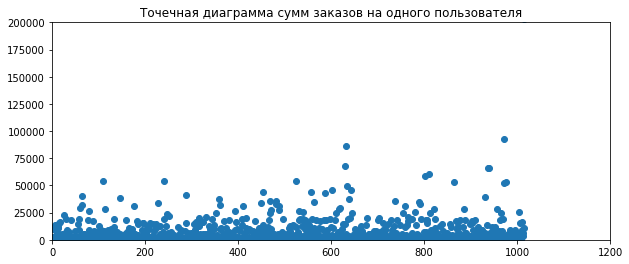

In [20]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(10,4))
plt.title('Точечная диаграмма сумм заказов на одного пользователя')
plt.axis([0, 1200, 0, 200000])
plt.scatter(x_values, orders['revenue'])

Судя по графику, большенство пользователей делаю заказы на сумму не больше 25000 рублей

9) Посчитаем 95-й и 99-й перцентили сумм заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [21]:
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


10) Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным

Будем испоьзовать критерий Уилкоксона-Манна-Уитни, т.к. он работает с рангами, — номерами значений в упорядоченном ряду, — никак не учитывая сами значения. Всегда используем его, когда имеются выбросы

Будем проверять гипотезы:
- H1 - По неочищенным данным в конверсии групп A и B РАЗНИЦА СТАТИСТИЧЕСКИ ЗНАЧИМА
- H0 - По неочищенным данным РАЗЛИЧИЙ в конверсии групп A и B НЕТ

In [22]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
ordersByUsersA.columns = ['visitorId', 'orders']
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
ordersByUsersB.columns = ['visitorId', 'orders']

list_orders_1 =[]
for i in range(0,(visitors[visitors['group']=='A']['visitors'].sum()-len(ordersByUsersA))):
    list_orders_1.append(0)
orders_by_non_purchased_users_A = pd.Series(data = list_orders_1, name = 'orders')

list_orders_2 =[]
for i in range(0,(visitors[visitors['group']=='B']['visitors'].sum()-len(ordersByUsersB))):
    list_orders_2.append(0)
orders_by_non_purchased_users_B = pd.Series(data = list_orders_2, name = 'orders')

sampleA = pd.concat([ordersByUsersA['orders'], orders_by_non_purchased_users_A], axis=0)
sampleB = pd.concat([ordersByUsersB['orders'], orders_by_non_purchased_users_B], axis=0)
print('\nОтносительный прирост конверсии группы B по отношению к группе A: {:.3f}'.format(sampleB.mean()/sampleA.mean()-1))
alpha = 0.05
results = st.mannwhitneyu(sampleA, sampleB)
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевую гипотезу отвергнуть не удалось')


Относительный прирост конверсии группы B по отношению к группе A: 0.160
P-value: 0.011018084110014696
Отвергаем нулевую гипотезу


11) Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Проверим гипотезы:
- H1 - По неочищенным данным РАЗНИЦА в средних чеках в группах A и B СТАТИСТИЧЕСКИ ЗНАЧИМА
- H0 - По неочищенным данным РАЗЛИЧИЙ в средних чеках в группах A и B НЕТ

In [23]:
print('Относительное изменение среднего чека в группе B по отношению группы A: {:.3f}'.format(
orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))
results = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Отвергнуть нулевую гипотезу не удалось')

Относительное изменение среднего чека в группе B по отношению группы A: 0.287
P-value: 0.8294908998149533
Отвергнуть нулевую гипотезу не удалось


12) Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным

Ранее мы уже выяснили, что подавляющее большинство пользователей не делает более 2 заказов и сумма 1 покупки в большинстве случаев не превышает 28000 деняг. Очистим данные от аномальных пользователей с превышающими данные лимиты значениями.

In [24]:
#зададим предельные кол-во заказов и сумму покупки для формирования списка аномальных пользователей
limit_orders = 2
limit_revenue = 28000

In [25]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders']>limit_orders]['visitorId'], 
                                ordersByUsersB[ordersByUsersB['orders']>limit_orders]['visitorId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue']>limit_revenue]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print('Кол-во аномальных пользователей: {}'.format(len(abnormalUsers)))

Кол-во аномальных пользователей: 55


Проверим гипотезы:
- H1 - По очищенным данным в конверсии групп A и B РАЗНИЦА СТАТИСТИЧЕСКИ ЗНАЧИМА!
- H0 - По очищенным данным РАЗЛИЧИЙ в конверсии групп A и B НЕТ

In [26]:
sampleAFiltered = pd.concat([
    ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
    orders_by_non_purchased_users_A
], axis = 0)
sampleBFiltered = pd.concat([
    ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
    orders_by_non_purchased_users_B
], axis = 0)
print('\nОтносительный прирост конверсии группы B по отношению к группе A после очистки данных: {:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))
results = st.mannwhitneyu(sampleAFiltered, sampleBFiltered)
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Отвергнуть нулевую гипотезу не удалось')


Относительный прирост конверсии группы B по отношению к группе A после очистки данных: 0.189
P-value: 0.00945335018662552
Отвергаем нулевую гипотезу


13) Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

Проверим гипотезы:
- H1 - По очищенным данным РАЗНИЦА в средних чеках в группах A и B СТАТИСТИЧЕСКИ ЗНАЧИМА
- H0 - По очищенным данным РАЗЛИЧИЙ в средних чеках в группах A и B НЕТ

In [27]:
print('Относительное изменение среднего чека в группе B по отношению группы A после очистки данных: {:.3f}'.format(
orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()\
/orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()-1))
       
       
results = st.mannwhitneyu(orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
                             orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Отвергнуть нулевую гипотезу не удалось')

Относительное изменение среднего чека в группе B по отношению группы A после очистки данных: -0.022
P-value: 0.7616880562749192
Отвергнуть нулевую гипотезу не удалось


14) Решение по результатам теста

Кумулятивные метрики по выручке, среднему чеку и конверсии почти все время лидировали в группе B. У нас на некоторое время возникли сомнения из-за резких колебаний на графике кумулятивного среднего чека в группе B до очистки данных от аномальных пользователей. Наши сомнения подтвердились на этот счет, т.к. после очистки разница между средними чеками стала минимальна, но это не даёт нам повода сомневаться в проведении теста и его результатах. До и после очистки данных, показатель конверсии в группе B больше показателя в группе A - сначала на 14% до и на 17% после очистки данных. Данная разница показателей конверсии между группами и до и после очистки данных является СТАТИСТИЧЕСКИ ЗНАЧИМОЙ, что пользволяет нам сделать вывод о том, что мы можем остановить наш A/B тест и зафиксировать победу группы B!